In [14]:
import jax
import jax.numpy as jnp
import module_control as qc
from tqdm import tqdm
import matplotlib.pyplot as plt
cmap = plt.cm.Spectral #colors

In [6]:
n=6
para_per_gate = 30
total_t = 8.
a_max=4.
constrain_lower=jnp.array([-a_max,0,0])
constrain_upper=jnp.array([a_max,jnp.sqrt(a_max),1.0])
#ini_params = jax.random.truncated_normal(jax.random.PRNGKey(899), lower=constrain_lower[:, None], upper=constrain_upper[:, None], shape=(3, para_per_gate))
div = 6
ini_params= jax.random.uniform(jax.random.PRNGKey(71189), minval=constrain_lower[:, None], maxval=constrain_upper[:, None], shape=(3, div))
ini_params = jnp.repeat(ini_params,int(para_per_gate/div), axis=-1)
mom_trans = qc.get_momentum_eigenstates(n,0)
h0 = (mom_trans@qc.real_vander_ising_H(n,qc.ring(n))@mom_trans.T)
spin_ops = jnp.array([qc.sym_col_sigmas(n,0,mom_trans),qc.sym_col_sigmas(n,1,mom_trans),qc.sym_col_sigmas(n,2,mom_trans)])
ini = mom_trans@qc.css(0,0,n)
sq_dir = jnp.array([0.,1.,0.])
mean_dir = jnp.array([0.,0.,1.])
print(ini.size)
learn_params = {
    'learning_steps': 4000, #max number of steps
    'ini_learning_rate' : 0.04, # initial learning rate
    'patience': 400, # steps the algorithm will wait to reduce the learning rate if the cost function does not decrease
    'spin_lenght': 0., #desired spin length
    'spin_focus': 0., #how much do you care about the spin length, 0=>Not at all
    'first_smooth': 0.,#1.8/para_per_gate, # First derivative hyperparameter
    'second_smooth': 0., #0.21/para_per_gate, # Second derivative hyperparameter
    'duration': 0.005, # duration hyperparameter
    'limit_amplitude':2.*a_max/qc.one,  # limit of the amplitude when X and Z parameters are transformed
    'ortho_hyper':2.,
    'spin_lenght_hyper':0.,
}
squeezing, best_params ,ss, dif, leng= qc.jax_control_squeezing_mod(h0, spin_ops, sq_dir,mean_dir, ini, total_t, n, ini_params, learn_params)

14


Once we find the optimized pulses, we can run simulate the unitary time evolution using this pulses

In [ ]:
nt_high, pz_high , px_high =qc.get_new_time_and_params(best_params, total_t) # Here we get the pulses ready to be used
res_1 = qc.control_tevol([pz_high, px_high], nt_high, [spin_ops[2],spin_ops[0]], h0, ini) # Run the simulation using DynamiQs

Compute observables 

In [9]:
jz = qc.vOv(spin_ops[2]/n, res_1.states)
jy = qc.vOv(spin_ops[1]/n, res_1.states)
jx = qc.vOv(spin_ops[0]/n, res_1.states)
varx = qc.varO(spin_ops[0],res_1.states)/n
vary = qc.varO(spin_ops[1],res_1.states)/n
varz = qc.varO(spin_ops[2],res_1.states)/n

Text(0, 0.5, 'Var $J_y$')

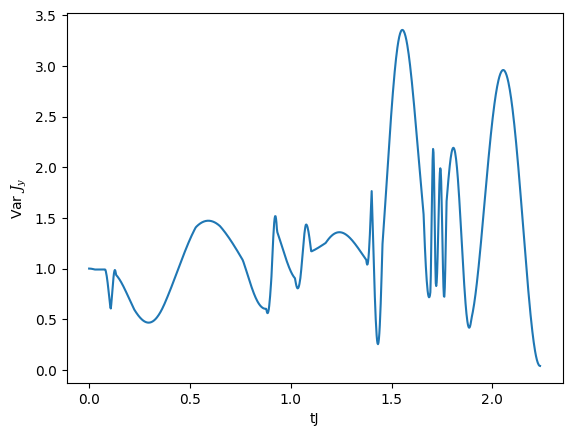

In [16]:
time = jnp.linspace(0., nt_high[-1],vary.size)
plt.plot(time, vary)
plt.xlabel('tJ')
plt.ylabel(r'Var $J_y$')

Let's see the pulses

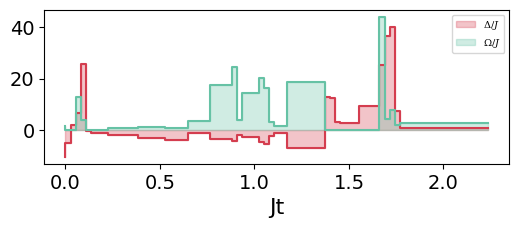

In [15]:
pzf_0 = jnp.append(pz_high, pz_high[-1] )
pxf_0 = jnp.append(px_high, px_high[-1] )
plt.subplots(figsize=(6, 2))
plt.step(nt_high, pzf_0, color=cmap(0.1))
plt.fill_between(nt_high, pzf_0, step="pre", color=cmap(0.1), alpha=0.3, label=r'$\Delta/J$')
plt.fill_between(nt_high, pxf_0, step="pre", color=cmap(0.8), alpha=0.3, label=r'$\Omega/J$')
plt.step(nt_high, pxf_0,color=cmap(0.8))
plt.xlabel('Jt', fontsize=16)
plt.tick_params('both', labelsize=14)
plt.legend(fontsize=7)